In [2]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 7.6 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install getdist

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.3/777.3 KB 7.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for getdist: filename=GetDist-1.4-py3-none-any.whl size=226622 sha256=5633388f69fb6af23e28b3bb1ae91fc4d4e0a479439c72f3b961f9bfe65801fd
  Stored in directory: /home/prakharb16/.cache/pip/wheels/33/eb/f0/b6b989b78dcd1605e2150783e3922e274b3cc21c0dd31e51a5
Successfully built getdist
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install emcee


Defaulting to user installation because normal site-packages is not writeable
  Using cached emcee-3.1.3-py2.py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install -U emcee

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize
from scipy.special import erf
from matplotlib import cm
import scipy.integrate
from scipy import optimize
from scipy.integrate import odeint
from scipy import integrate as integrate
from scipy.interpolate import CubicSpline
from scipy.interpolate import lagrange
from scipy import interpolate


In [4]:

import getdist
from getdist import plots, MCSamples
import time
import emcee

In [5]:
plt.style.use('default')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [6]:
def E( parameters,z):  
    omega=parameters[0]
    alpha=parameters[1]
    #Ho= parameters[2]
    #print(alpha)
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = 4.0/(9.0*(a**3))
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = (1/32*np.pi)*(0.5*phi_dot**2 + V)
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]
    else:
        i=i[0]
    #print(i)
    rho_critical = rho_m[i]+rho_phi[i]
    a_z = 1/(1+z)
    #print(sol[i,0])
    a = a/sol[i,0]
    j = np.where(a >= a_z)[0]
    j=j[0]
    #print(j)
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)

In [7]:
def E_sol(rho_critical,rho_m,rho_phi,a,z):
    a_z = 1/(1+z)
    #print(sol[i,0])
    
    j = np.where(a >= a_z)[0]
    #print(j)
    if(len(j)>1):
        j=j[0]
    else:
        j=len(a)-1
    #print(j)
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)  

In [8]:
def erf_new(x):
    return ((4/np.pi)**(1/2))*(erf(x)-erf(0))

In [9]:
def alphaf(parameters,sigma_Ho,sigma,z,E_array):
    #sigma,z,H_obs are vectors

    n = len(sigma)
    alpha0=1/(sigma_Ho)**2
    for i in range(n):
        alpha0 = alpha0 + (E_array[i]/sigma[i])**2
        
    return alpha0

In [10]:
def beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array):
    n = len(sigma)
    beta0=Ho/((sigma_Ho)**2)
    for i in range(n):
        beta0 = beta0 + (E_array[i]*H_obs[i]/((sigma[i])**2))
        
    return beta0

In [11]:
def gamma(Ho,sigma_Ho,H_obs,sigma,E_array):
    n = len(sigma)
    gamma0=(Ho/(sigma_Ho))**2
    for i in range(n):
        gamma0 = gamma0 + (H_obs[i]/sigma[i])**2
        
    return gamma0 

In [12]:
def Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    omega=parameters[0]
    alpha=parameters[1]
    t_initial = 10**(-5)
    t_final = 150
    dt = 10**(-4)
    t = np.arange(0., t_final, dt)
    
    #print(y0(alpha))
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = 4.0/(9.0*(a**3))
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = (1/6)*(0.5*phi_dot**2 + V)
    omega_exp = rho_m/(rho_phi+rho_m)
    #i = np.where(omega_exp>=omega)
    #i=i[0]
    #if (len(i)>1):
        #i=i[-1]
    #else:
        #i=len(t)-1
    #print(i)
    omega_exp = np.flipud(omega_exp)
    omega_exp_diff = omega_exp[1:]
    omega_exp_diff = np.diff(omega_exp)
    zeros= np.where(omega_exp_diff>0)
    zeros=zeros[0]
    #print(zeros)
    zeros=zeros+1
    omega_exp_new= omega_exp[zeros]
    aflip = np.flipud(a[zeros])
    g = interpolate.interp1d(omega_exp_new,aflip,fill_value = "extrapolate")
    #size = omega_exp.size
    a1 = g(omega)
    #print(a1)
    rm = interpolate.interp1d(a,rho_m,fill_value = "extrapolate")
    rp =interpolate.interp1d(a,rho_phi,fill_value = "extrapolate")
    #rho_critical = rho_m[i]+rho_phi[i]
    rho_critical = rm(a1)+rp(a1)
    #print(rho_critical)
    #a = a/sol[i,0]
#     z_values = (1/a)-1
#     omega_m_theo=rho_m/rho_critical
#     omega_phi_theo=rho_phi/rho_critical
#     start = time.time()
#     E_values = np.sqrt(omega_m_theo+omega_phi_theo)
#     z_values = np.flipud(z_values)
#     E_values = np.flipud(E_values)
#     z_bw_0_1000 = np.where((z_values>=0) & (z_values<=20))
#     z_bw_0_1000_values =z_values[z_bw_0_1000]
#     E_bw_0_1000_values= E_values[z_bw_0_1000]
#     #print(z_bw_0_1000_values)
#     f = CubicSpline(z_bw_0_1000_values, E_bw_0_1000_values)
    a_obs = 1/(1+z_obs)
    a_obs = a_obs*a1
    omega_m_obs = rm(a_obs)/rho_critical
    omega_phi_obs = rp(a_obs)/rho_critical
    E_array = np.sqrt(omega_m_obs+omega_phi_obs)
    
    end= time.time()
    #print(end-start)
    #E_array= f(z_obs)
    #print(E_array)
    alpha0= alphaf(parameters,sigma_Ho,sigma,z,E_array)
    beta0= beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array)
    gamma0= gamma(Ho,sigma_Ho,H_obs,sigma,E_array)
    LH1= (1/(4*alpha0*((sigma_Ho)**2)))**(1/2)
    LH2= np.exp(-gamma0/2+(((beta0)**2)/(2*alpha0)))
    LH3 = 1+ erf_new(beta0/((2*alpha0)**(1/2)))
    
    return (LH1*LH2*LH3)

In [13]:
def Chi_sq(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return (-2*np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)))

In [14]:
def log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z))

In [15]:
def log_prior(parameters):
    omega,alpha = parameters
    if 0.0 < omega < 2 and (0.0 < alpha < 0.1 or 0.1< alpha < 5):
        return 0.0
    return -np.inf

In [16]:
def log_probability(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
   
    return lp + log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)

In [15]:
print(E([0.30,0.01,70],1.965))

NameError: name 'KG_eqn' is not defined

In [17]:
def kappa(alpha):
    #print(alpha)
    #print(type(alpha))
    p1= (8*alpha+32)/(3*alpha+6)
    p2= ((2*(alpha**2)+4*alpha)/3)**(alpha/2)
    #print(f"kappa:{p1*p2}")
    return p1*p2

In [18]:
print(kappa(0.5))
print((1/12)*kappa(0.1)*0.13486911**(-0.1))

4.586125402580961
0.48047102316806106


In [19]:
def y0(alpha):
    t0 = 10**(-5)
    a_initial = (t0**(2./3.))
    phi_initial =   ((2.*alpha*(alpha+2.)/3.)**(1/2.))*((t0)**(2./(alpha+2.)))
   
    phi_dot_initial = (((8./3.)*alpha*(1./(alpha + 2.)))**(1./2.))/(t0)**(alpha/(alpha + 2.))
    
    Ho = 70 # Hubble parameter today in units of 100 km/s/Mpc (Planck 2015)
    rho_cr0 = 3*Ho**2/(8*np.pi)
    #h = 0.678 # Hubble parameter today in units of 100 km/s/Mpc (Planck 2015)
    #rho_cr0 = 8.0992*(h**2)*10**(-47) / (2.435*10**18)**4
    # calculate the matter density today
    
    #Omega_m = 0.28
    #rho_m0 = Omega_m*rho_cr0
    #rho_initial = rho_m0/(a_initial**3) # initial value for the matter density
    
    return a_initial,phi_initial,phi_dot_initial
    #,rho_initial

In [20]:
print(y0(4))

(0.0004641588833612781, 0.08617738760127537, 2872.579586709177)


In [21]:
print(y0(np.array([0.01,0.02,0.03])))

(0.0004641588833612781, array([1.22582372e-06, 1.83928913e-06, 2.38866168e-06]), array([0.12197251, 0.18210783, 0.23533613]))


In [21]:
t_initial = 10**(-5)
t_final = 150
dt = 10**(-3)
t = np.arange(0., t_final, dt)
print(t.shape)

    

(150000,)


In [22]:
def KG_eqn(y, t, parameters):
    #a,phi,phi_dot,rho_m = y
    a,phi,phi_dot = y
    rho_m = 4.0/(9.0*a**3)
    alpha=parameters[1]
    kappa_alpha = kappa(alpha)
    mp = 1
    V = (1/2)*kappa_alpha*mp**2/(phi)**(alpha)
    rho_phi = (1/6)*(0.5*phi_dot**2 + V)
    Hubble_rate = np.sqrt( (rho_phi + rho_m))
    #dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
    dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)) ]
    return dydt

In [23]:
parameters = [0.30,0.01]
Ho=70

In [24]:
from scipy.integrate import odeint
#sol = odeint(KG_eqn, y0(0.01), t, args=(parameters,))
print(68.8*E(parameters,2.30))

NameError: name 't' is not defined

In [25]:
print(sol[0:1678,2])

NameError: name 'sol' is not defined

In [26]:
a = sol[:,0]
phi=sol[:,1]
phi_dot=sol[:,2]
rho_m = sol[:,3]
H=[]
alpha = 0.01
print(phi,phi_dot,rho_m)
kappa_alpha = kappa(alpha)
V = (1/2)*kappa_alpha/(phi)**(alpha)
rho_phi = 0.5*phi_dot**2 + V
Hubble_rate = np.sqrt((8*np.pi/3)* (rho_phi + rho_m))
print(V)

print(Hubble_rate[16906])


NameError: name 'sol' is not defined

In [25]:
Data = pd.read_csv("Hdata - Table 1-Copy1.csv")
print(Data)
Data = Data.to_numpy()
z_obs = Data[:,1]
H_obs = Data[:,2]
sigma_obs = Data[:,3]
print(z_obs)

    Unnamed: 0      z      H  Sigma
0          NaN  0.070   69.0   19.6
1          NaN  0.100   69.0   12.0
2          NaN  0.120   68.6   26.2
3          NaN  0.170   83.0    8.0
4          NaN  0.179   75.0    4.0
5          NaN  0.199   75.0    5.0
6          NaN  0.200   72.9   29.6
7          NaN  0.270   77.0   14.0
8          NaN  0.280   88.8   36.6
9          NaN  0.350   76.3    5.6
10         NaN  0.352   83.0   14.0
11         NaN  0.400   95.0   17.0
12         NaN  0.440   82.6    7.8
13         NaN  0.480   97.0   62.0
14         NaN  0.593  104.0   13.0
15         NaN  0.600   87.9    6.1
16         NaN  0.680   92.0    8.0
17         NaN  0.730   97.3    7.0
18         NaN  0.781  105.0   12.0
19         NaN  0.875  125.0   17.0
20         NaN  0.880   90.0   40.0
21         NaN  0.900  117.0   23.0
22         NaN  1.037  154.0   20.0
23         NaN  1.300  168.0   17.0
24         NaN  1.430  177.0   18.0
25         NaN  1.530  140.0   14.0
26         NaN  1.750  202.0

In [26]:
Ho= 68
sigma_Ho=2.8

In [27]:
print(np.arange(0.1,0.7,0.01))

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69]


In [49]:

for omega in np.arange(0.01,5,0.2):
    start = time.time()
    print(Chi_sq([0.14,omega],73.8,2.4,H_obs,sigma_obs,z_obs))
    print(omega)
    end =time.time()
    #print(end-start)

55.12146794482734
0.01
50.88978440855571
0.21000000000000002
47.27731483598414
0.41000000000000003
44.22675979315788
0.6100000000000001


KeyboardInterrupt: 

In [74]:
for omega in np.arange(1e-6,0.7,1e-5):
    start = time.time()
    print(Chi_sq([0.25,omega],73.8,2.4,H_obs,sigma_obs,z_obs))
    print(omega)
    end =time.time()
    print(end-start)

20.518215108656772
1e-06
0.08621454238891602
20.518271546908288
1.1000000000000001e-05
0.033759117126464844
20.518327985738804
2.1000000000000002e-05
0.032762765884399414
20.518384425170222
3.1e-05
0.03310513496398926
20.51844086457359
4.1e-05
0.03356122970581055
20.5184973046054
5.1e-05
0.03365755081176758
20.51855374596508
6.1000000000000005e-05
0.034394264221191406
20.51861018737335
7.1e-05
0.03763580322265625
20.518666629718847
8.1e-05
0.035616397857666016
20.51872307201775
9.1e-05
0.03505825996398926
20.51877951584213
0.000101
0.035628318786621094
20.518835959564665
0.000111
0.03593730926513672
20.5188924041237
0.00012100000000000001
0.0366969108581543
20.518948849221736
0.000131
0.036408424377441406
20.519005295128224
0.000141
0.034917354583740234
20.51906173601167
0.000151
0.037290096282958984
20.5191181807445
0.000161
0.037552833557128906
20.519174628579513
0.000171
0.037638187408447266
20.519231076896958
0.000181
0.03903603553771973
20.519287525304403
0.000191
0.03784418106079

20.526965429217768
0.001551
0.03709888458251953
20.527021913084933
0.001561
0.03597402572631836
20.527078397577615
0.0015710000000000001
0.03619503974914551
20.527134882645
0.001581
0.03617429733276367
20.527191368282512
0.001591
0.03626275062561035
20.527247854499702
0.001601
0.03640604019165039
20.527304340549005
0.001611
0.03749489784240723
20.52736082790987
0.001621
0.037377119064331055
20.52741731584405
0.001631
0.036688804626464844
20.52747380435564
0.001641
0.036486148834228516
20.52753029343961
0.0016510000000000001
0.03626370429992676
20.5275867830996
0.0016610000000000001
0.03664207458496094
20.527643272701756
0.001671
0.03757667541503906
20.527699763509986
0.001681
0.0379793643951416
20.527756254896083
0.001691
0.03653287887573242
20.527812746893453
0.001701
0.036725759506225586
20.527869239467783
0.001711
0.036696672439575195
20.527925732617263
0.001721
0.036023855209350586
20.5279822263478
0.0017310000000000001
0.03759312629699707
20.528038720141026
0.0017410000000000001
0

20.535388562638385
0.0030410000000000003
0.038047075271606445
20.535445155360833
0.0030510000000000003
0.037691593170166016
20.53550174667697
0.0030610000000000004
0.03687095642089844
20.535558335625378
0.0030710000000000004
0.03680419921875
20.5356149280822
0.0030810000000000004
0.03699851036071777
20.535671524506125
0.0030910000000000004
0.03694510459899902
20.535728118125046
0.0031010000000000005
0.037813663482666016
20.535784712316403
0.0031110000000000005
0.03747248649597168
20.535841303552424
0.0031210000000000005
0.03683781623840332
20.535897898888205
0.0031310000000000005
0.03695058822631836
20.535954494800052
0.0031410000000000006
0.03679966926574707
20.536011091190428
0.0031510000000000006
0.03771829605102539
20.536067688253947
0.003161
0.03864908218383789
20.53612428589445
0.003171
0.03758525848388672
20.53618088409663
0.0031810000000000002
0.03728961944580078
20.536237482883354
0.0031910000000000003
0.03716278076171875
20.53629408224842
0.0032010000000000003
0.0368442535400

20.543433904005873
0.0044610000000000006
0.04116487503051758
20.543490674473738
0.004471
0.03860211372375488
20.543547445288183
0.004481000000000001
0.04153013229370117
20.543604216906317
0.004491
0.04166817665100098
20.543660989100516
0.004501000000000001
0.0372312068939209
20.543717761867146
0.004511
0.036103248596191406
20.543774535206204
0.004521000000000001
0.037780046463012695
20.54383130912224
0.004531
0.03697538375854492
20.543888074116076
0.004541000000000001
0.041066646575927734
20.54394484917493
0.004551
0.0443110466003418
20.544001624808526
0.004561000000000001
0.04152345657348633
20.544058401016862
0.004571
0.04477119445800781
20.54411517779721
0.004581000000000001
0.04055953025817871
20.54417196485395
0.0045910000000000005
0.041303157806396484
20.544228742792466
0.004601000000000001
0.0418095588684082
20.5442855213066
0.0046110000000000005
0.03796887397766113
20.54434229078262
0.004621
0.041043996810913086
20.544399070439614
0.004631000000000001
0.040010690689086914
20.54

KeyboardInterrupt: 

In [37]:
best_fit_params = minimize (Chi_sq,x0=[0.27,0.0001],args=(68,2.8,H_obs,sigma_obs,z_obs),method='L-BFGS-B',bounds=[(0,2),(0,5)])
print(best_fit_params)

<ipython-input-24-8d130fa533c9>:12: RuntimeWarning: invalid value encountered in double_scalars
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)) ]
<ipython-input-33-60a254515200>:14: RuntimeWarning: divide by zero encountered in true_divide
  rho_m = 4.0/(9.0*(a**3))
<ipython-input-33-60a254515200>:18: RuntimeWarning: invalid value encountered in true_divide
  omega_exp = rho_m/(rho_phi+rho_m)
<ipython-input-33-60a254515200>:27: RuntimeWarning: divide by zero encountered in true_divide
  a = a/sol[i,0]
<ipython-input-33-60a254515200>:27: RuntimeWarning: invalid value encountered in true_divide
  a = a/sol[i,0]
<ipython-input-11-2317c60a75cb>:2: RuntimeWarning: divide by zero encountered in log
  return (-2*np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)))


      fun: 18.71861206394749
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , 17.48856242])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([2.7e-01, 1.0e-04])


In [48]:
bfp = dict()
bfp['DA'] = optimize.dual_annealing(Chi_sq, [(0.1,0.7),(0.01,5)],args =(73.8,2.4,H_obs,sigma_obs,z_obs) )
print(bfp["DA"])

     fun: 20.553044869295917
 message: ['Maximum number of iteration reached']
    nfev: 4061
    nhev: 0
     nit: 1000
    njev: 20
  status: 0
 success: True
       x: array([0.25312761, 0.01      ])


In [ ]:
def z_equality(a,rho_critical):
    omega_m = rm(a)/rho_critical
    omega_phi = rp(a)/rho_critical
    

In [32]:
parameters = [2.88169954e-01, 1.00000000e-05]
omega,alpha=parameters
sol_equality = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
a=sol_equality[:,0]
phi=sol_equality[:,1]
phi_dot = sol_equality[:,2]
rho_m = 4.0/(9.0*(a**3))
kappa_alpha = kappa(alpha)
V = (1/2)*kappa_alpha/(phi)**(alpha)
rho_phi = (1/6)*(0.5*phi_dot**2 + V)
omega_exp = rho_m/(rho_phi+rho_m)
omega_exp = np.flipud(omega_exp)
omega_exp_diff = omega_exp[1:]
omega_exp_diff = np.diff(omega_exp)
zeros= np.where(omega_exp_diff>0)
zeros=zeros[0]
#print(zeros)
zeros=zeros+1
omega_exp_new= omega_exp[zeros]
aflip = np.flipud(a[zeros])

g = interpolate.interp1d(omega_exp_new,aflip)
a1 = g(omega)
#print(a1)
rm = interpolate.interp1d(a,rho_m)
rp = interpolate.interp1d(a,rho_phi)
#rho_critical = rho_m[i]+rho_phi[i]
rho_critical = rm(a1)+rp(a1)
a=a/a1
print(rho_critical)
omega_m = rho_m/rho_critical
omega_phi = rho_phi/rho_critical
womega_phi = (phi_dot**2-kappa_alpha/phi**alpha)/(phi_dot**2+kappa_alpha/phi**alpha)
eqn = abs(omega_m+ omega_phi*(1+3*womega_phi))
i_equality = np.argsort(eqn)
print(eqn[i_equality])
eqn = eqn[i_equality]
z_eq = 1/a[i_equality]-1
h = interpolate.interp1d(eqn,z_eq,fill_value="extrapolate")
print(h(0.))

real = np.where(z_eq>=0)
print(z_eq)

0.6239414557613749
[2.36900626e-03 2.56557998e-03 7.32645304e-03 ... 1.78078263e+05
 7.12317854e+05 7.12317543e+24]
0.729157279132151
[7.05438889e-01 7.03470801e-01 7.07411530e-01 ... 8.42248514e+01
 1.34286052e+02 2.91464726e+08]


In [33]:
start = time.time()
bfp2 = dict()
bfp2['DA'] = optimize.dual_annealing(Chi_sq, [(0.1,0.7),(0.01,2)],args =(68,2.8,H_obs,sigma_obs,z_obs) )
print(bfp2["DA"])
end = time.time()
print(end-start)
#print(bfp)
#print(np.round((bfp.x),2))
#print(np.round((bfp.fun),2))

     fun: 18.081797514453694
 message: ['Maximum number of iteration reached']
    nfev: 4049
    nhev: 0
     nit: 1000
    njev: 16
  status: 0
 success: True
       x: array([0.28807432, 0.01      ])
138.3314003944397


In [33]:
parameters = [2.53727071e-01, 1.00000000e-05]
omega,alpha=parameters
sol_equality = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
a=sol_equality[:,0]
phi=sol_equality[:,1]
phi_dot = sol_equality[:,2]
rho_m = 4.0/(9.0*(a**3))
kappa_alpha = kappa(alpha)
V = (1/2)*kappa_alpha/(phi)**(alpha)
rho_phi = (1/6)*(0.5*phi_dot**2 + V)
omega_exp = rho_m/(rho_phi+rho_m)
omega_exp = np.flipud(omega_exp)
omega_exp_diff = omega_exp[1:]
omega_exp_diff = np.diff(omega_exp)
zeros= np.where(omega_exp_diff>0)
zeros=zeros[0]
#print(zeros)
zeros=zeros+1
omega_exp_new= omega_exp[zeros]
aflip = np.flipud(a[zeros])

g = interpolate.interp1d(omega_exp_new,aflip)
a1 = g(omega)
#print(a1)
rm = interpolate.interp1d(a,rho_m)
rp = interpolate.interp1d(a,rho_phi)
#rho_critical = rho_m[i]+rho_phi[i]
rho_critical = rm(a1)+rp(a1)
a=a/a1
print(rho_critical)
omega_m = rho_m/rho_critical
omega_phi = rho_phi/rho_critical
womega_phi = (phi_dot**2-kappa_alpha/phi**alpha)/(phi_dot**2+kappa_alpha/phi**alpha)
eqn = abs(omega_m+ omega_phi*(1+3*womega_phi))
i_equality = np.argsort(eqn)
print(eqn[i_equality])
eqn = eqn[i_equality]
z_eq = 1/a[i_equality]-1
h = interpolate.interp1d(eqn,z_eq,fill_value="extrapolate")
print(h(0.))

real = np.where(z_eq>=0)
print(z_eq)

0.5952011280783621
[2.48339788e-03 2.68946350e-03 7.68022364e-03 ... 1.86677083e+05
 7.46713368e+05 7.46713041e+24]
0.8327126475526915
[8.07573816e-01 8.05487863e-01 8.09664595e-01 ... 8.93287775e+01
 1.42388032e+02 3.08919898e+08]


In [976]:
print(Chi_sq([0.29,0.0001],74,68,2.8,H_obs,sigma_obs,z_obs,N))

[ 46.73843358  49.07050131  50.6783947   54.90566107  55.70094723
  57.50942125  57.60135957  64.4505272   65.50272627  73.5063504
  73.75359464  79.74192816  84.73317609  89.72442402 103.82469943
 104.69816781 114.68066368 120.91972359 127.2835647  139.01299734
 139.63690333 142.1325273  159.22755146 192.0450066  208.26656238
 220.74468221 248.19654583 316.82620487]
263.60732117728344


<ipython-input-827-e42e0297d925>:5: RuntimeWarning: invalid value encountered in log
  P2= kappa(alpha)*(np.exp((-alpha)*np.log(phi)))/12
<ipython-input-885-3bf6cdf1d518>:7: RuntimeWarning: invalid value encountered in double_scalars
  dydt = [phi_pr,-(3.0 + HdotoH2)*phi_pr - kappa_alpha*(phi**(-alpha-1))/(2*Hsquared) ]
<ipython-input-827-e42e0297d925>:5: RuntimeWarning: divide by zero encountered in log
  P2= kappa(alpha)*(np.exp((-alpha)*np.log(phi)))/12
<ipython-input-827-e42e0297d925>:6: RuntimeWarning: overflow encountered in square
  P3= 1- ((phi_pr)**2)/12
<ipython-input-827-e42e0297d925>:7: RuntimeWarning: invalid value encountered in true_divide
  return (P1+P2)/P3
<ipython-input-964-14e45ff3c626>:7: RuntimeWarning: invalid value encountered in sqrt
  H_theo= np.sqrt(Hsq( parameters,Ho,phi,phi_pr,N))


In [968]:
z_initial = 2100
z_final = 0
N_initial = N_efolds(z_initial)
N_final = N_efolds(z_final)
timesteps = 5000
N = np.linspace(N_initial, N_final, timesteps)
redshifts =  np.exp(-N) - 1
print(redshifts[4000])

3.612682008024761


In [957]:
print(-2*np.log(0.09814992513745828))

4.642518241991984


In [63]:
print(2.36874500e-05**(-0.01))

1.1123842134671111


In [73]:
n=100
xlist = np.linspace(0, 0.60, n)
ylist = np.linspace(0.000001, 5, n)
parameters = np.meshgrid(xlist, ylist,sparse=True)
X=parameters[0]
Y=parameters[1]
Y=np.reshape(Y,(100))
print(Y.shape)

Z=Chi_sq((X,Y),68,2.8,H_obs,sigma_obs,z_obs)
Z=np.zeros((n,n))
for i in range(n):
    for  j in range (n):
        #print(X[i])
        Z[i,j]= Chi_sq((xlist[i],ylist[j]),68,2.8,H_obs,sigma_obs,z_obs)

(100,)


ValueError: Initial condition y0 must be one-dimensional.

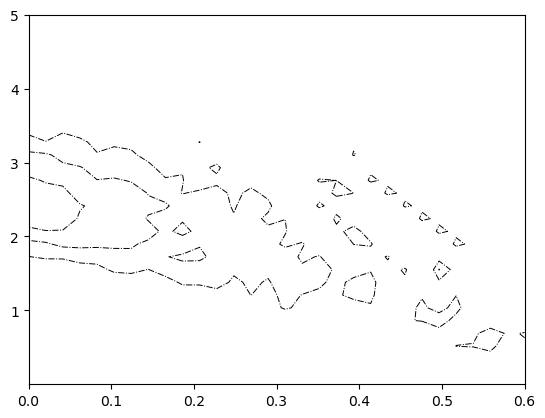

In [58]:
fig, ax1 = plt.subplots()

#drawing contour plot

cb = ax1.contour(X, Y, Z,levels=[17.63,19.93,23.80,28.71],colors="black",linewidths=0.7,linestyles="dashdot")

In [34]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [33]:
import emcee
from multiprocessing import Pool
with Pool() as pool:
    pos = [0.25312761, 0.01    ] + 1e-4 * np.random.randn(100, 2)
    nwalkers, ndim = pos.shape
    print("done0")
    #filename = "Ho68_new_phiCDM_new3.h5"
    #backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    print("done1")

    #print(best_fit_params)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(73.8,2.4,H_obs,sigma_obs,z_obs),pool=pool)
    start = time.time()
    sampler.run_mcmc(pos,10000, progress=True);
    end = time.time()
    print(end-start)

done0
done1


100%|█████████████████████████████████████| 10000/10000 [02:12<00:00, 75.75it/s]

132.03077030181885


In [30]:
tau = sampler.get_autocorr_time()
print(tau)
#tau = sampler.get_autocorr_time()
burnin =  int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

[nan nan]


/home/prakharb16/first_dir/first_env/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


ValueError: cannot convert float NaN to integer

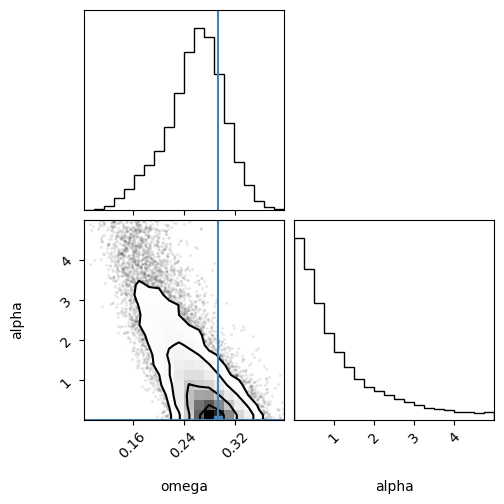

In [78]:
import corner
labels = ["omega","alpha"]
fig = corner.corner(
    flat_samples, labels=labels, truths= [0.29435933, 0.01217145]
);

In [41]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [4.55, 50, 95.45])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

NameError: name 'flat_samples' is not defined

In [29]:
#ndim = 2
#nsamp = 132400
samps = flat_samples
#samps2 = flat_samples2

In [30]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


(0.0, 5.0)

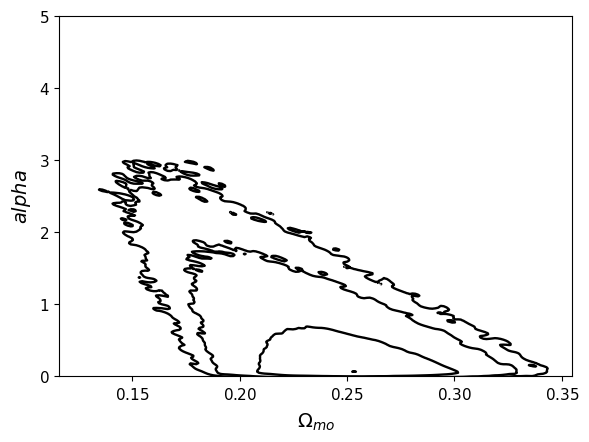

In [32]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 4
g.plot_2d(samples, 'omega', 'alpha');
ax1.set_ylim(0,5)


In [30]:
#import emcee
from multiprocessing import Pool
with Pool() as pool:
    pos = [0.25312761,0.02] + 1e-4 * np.random.randn(300, 2)
    nwalkers, ndim = pos.shape
    #print("done0")
    #filename = "Ho68_new_phiCDM_new3.h5"
    #backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    #print("done1")

    #print(best_fit_params)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(73.8,2.4,H_obs,sigma_obs,z_obs),pool=pool
    )
    start = time.time()
    sampler.run_mcmc(pos, 30000, progress=True);
    end = time.time()
    print(end-start)

  0%|                                                 | 0/30000 [00:00<?, ?it/s]/home/prakharb16/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████| 30000/30000 [29:42:57<00:00,  3.57s/it]

106980.01049304008


In [32]:
python -m pip install -U pytest h5py

SyntaxError: invalid syntax (1598779161.py, line 1)

In [31]:
tau = sampler.get_autocorr_time()
print(tau)
#tau = sampler.get_autocorr_time()
burnin =  int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples2 = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples2.shape))

[40.75981376 52.17119977]
burn-in: 104
thin: 20
flat chain shape: (448200, 2)


In [42]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples2[:, i], [4.55, 50, 95.45])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [34]:
#ndim = 2
#nsamp = 132400
samps2 = flat_samples2
#samps2 = flat_samples2

In [35]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples2 = MCSamples(samples=samps2,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


(0.0, 5.0)

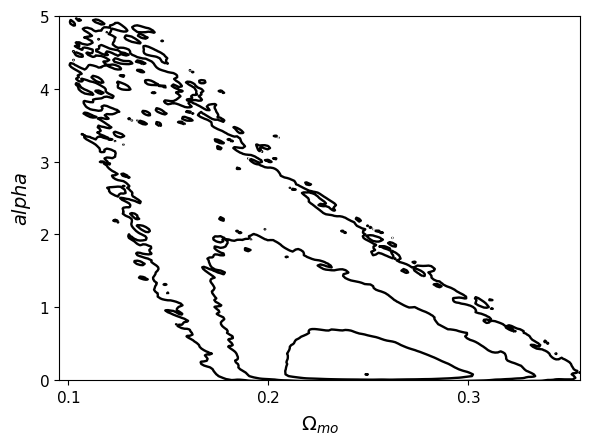

In [43]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples2.updateSettings({'contours': [0.001,0.68, 0.9545, 0.9971]})
g.settings.num_plot_contours = 4
g.plot_2d(samples2, 'omega', 'alpha');
ax1.set_ylim(0,5)


In [4]:
reader = emcee.backends.HDFBackend("Ho73.8_phiCDM.h5", read_only=True)
flatchain = reader.get_chain(flat=True)


In [6]:
tau = reader.get_autocorr_time(discard=0, thin=1)
print(tau)

[40.83026447 50.55767747]


In [39]:
pip install corner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


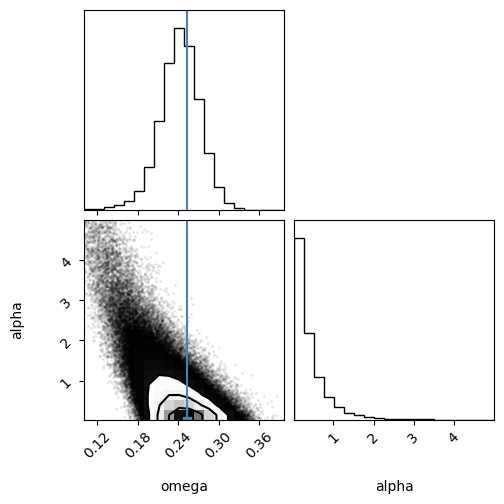

In [40]:
import corner
labels = ["omega","alpha"]
fig = corner.corner(
    flat_samples2, labels=labels, truths= [2.53516085e-01, 1.00000000e-05]
);

# Variable Moves


In [29]:
#import emcee
from multiprocessing import Pool
with Pool() as pool:
    pos = [0.25312761,0.0] + 1e-4 * np.random.randn(100, 2)
    nwalkers, ndim = pos.shape
    #print("done0")
    #filename = "Ho68_new_phiCDM_new3.h5"
    #backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    #print("done1")

    #print(best_fit_params)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(73.8,2.4,H_obs,sigma_obs,z_obs),pool=pool,
        moves=[
        (emcee.moves.WalkMove())
    ]
    )
    start = time.time()
    sampler.run_mcmc(pos, 5000, progress=True);
    end = time.time()
    print(end-start)

100%|████████████████████████████████████| 5000/5000 [11:48:31<00:00,  8.50s/it]

42517.77132964134


In [30]:
tau = sampler.get_autocorr_time()
print(tau)
#tau = sampler.get_autocorr_time()
burnin =  int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples3 = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples3.shape))

[19.52533809 30.34022357]
burn-in: 60
thin: 9
flat chain shape: (54800, 2)


In [31]:
#ndim = 2
#nsamp = 132400
samps3 = flat_samples3
#samps2 = flat_samples2

In [32]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples3 = MCSamples(samples=samps3,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


In [33]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples3[:, i], [4.55, 50, 95.45])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(0.0, 5.0)

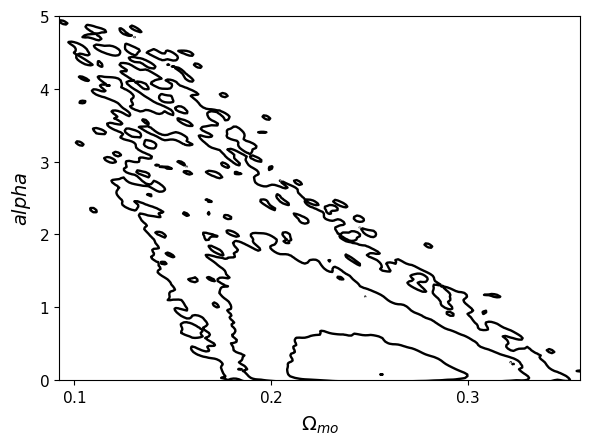

In [34]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples3.updateSettings({'contours': [0.001,0.68, 0.9545, 0.9971]})
g.settings.num_plot_contours = 4
g.plot_2d(samples3, 'omega', 'alpha');
ax1.set_ylim(0,5)


(0.0, 5.0)

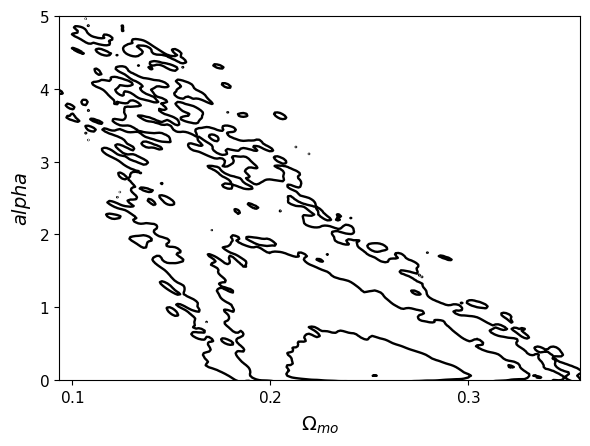

In [85]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples3.updateSettings({'contours': [0.001,0.68, 0.9545, 0.9971]})
g.settings.num_plot_contours = 4
g.plot_2d(samples3, 'omega', 'alpha');
ax1.set_ylim(0,5)


In [54]:
#import emcee
from multiprocessing import Pool
with Pool() as pool:
    pos = [0.25312761,0.02] + 1e-4 * np.random.randn(100, 2)
    nwalkers, ndim = pos.shape
    #print("done0")
    #filename = "Ho68_new_phiCDM_new3.h5"
    #backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    #print("done1")

    #print(best_fit_params)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(73.8,2.4,H_obs,sigma_obs,z_obs),pool=pool
        
    )
    start = time.time()
    sampler.run_mcmc(pos, 5000, progress=True);
    end = time.time()
    print(end-start)

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/home/prakharb16/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████| 5000/5000 [1:37:14<00:00,  1.17s/it]

5835.085494279861


In [55]:
tau = sampler.get_autocorr_time()
print(tau)
#tau = sampler.get_autocorr_time()
burnin =  int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples4 = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples3.shape))

[38.12599475 48.68548682]
burn-in: 97
thin: 19
flat chain shape: (49400, 2)


In [56]:
#ndim = 2
#nsamp = 132400
samps4 = flat_samples4
#samps2 = flat_samples2

In [57]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples4 = MCSamples(samples=samps4,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


In [59]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples4[:, i], [4.55, 50, 95.45])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(0.0, 5.0)

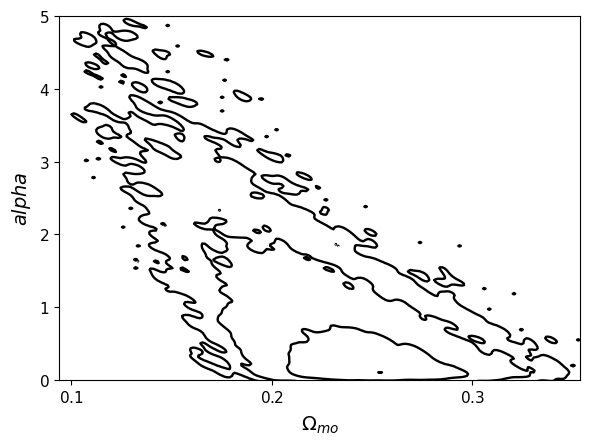

In [61]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples4.updateSettings({'contours': [0.001,0.68, 0.9545, 0.9971]})
g.settings.num_plot_contours = 4
g.plot_2d(samples4, 'omega', 'alpha');
ax1.set_ylim(0,5)